In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import cv2
import os
import time
import math
import tensorboard
import matplotlib.pyplot as plt
from IPython.display import clear_output

Prepare the training data for the discriminator first.

In [3]:
(train_set, train_label), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_set = train_set / 255.

In [5]:
train_set = train_set.reshape(-1, 28, 28, 1).astype('float32')

The idea is to train both the discriminator and the generator at the same time. The generator first receive some random noise input and generate an output which is a tensor in the shape of the image size. 

-Then the discriminator is fed with both real images as well as the fake images generated by the generator above. Then the discriminator calculates the total loss of its performance on classifying real and fake images, while the generator calculates the loss based on the fake images it generated. 

-The more the discriminator correctly identify those fake images, the higher the loss to the generator thus the generator will keep learning how to fool the discriminator. At the same time, the discriminator is also learning the spatial patterns of real images and fake images thus getting better at identifying fake images. 

-At each step we use the generator to generate a batch of output, feed the output as well as the real images to the discriminator, calculate costs for both model, then update both model's parameters. According to the Nash Equilibrium, the process should converge at the time that the discriminator can no more identify real and fake thus predicting a 50% 50% chance for each class.

-We first create a function to build the discriminator model. To let the discriminator fully study the spatial pattern instead of just looking at some special features, we are not using any pooling layer. To avoid the problem of diminishing gradients and speeds up training, use LeakyReLu instead of regular ReLu. 

In [6]:
def create_discriminator(input_shape = [28, 28, 1]):
    
    model = Sequential()
    model.add(Conv2D(128, (5, 5), strides = (2, 2), input_shape = input_shape, padding = 'same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    
    model.add(Dense(1))
    
    #model.compile(loss = loss, optimizer = optimizer, metrics = [metrics])
    
    return model

-The generator is built by using the Conv2DTranspose layer which can upsample inputs to a larger feature map. The input to the generator is just a random vector with any length. 100 is used here, but any number should be fine. 

-To let the Conv2DTranspose layer do its work, we need a Dense layer to create all pixels the Conv layer needs. At here, the design is that the final output image is construct by 32 feature maps, each feature map has a 28 by 28 size. Thus, the total number of pixels needed for the model is then 28.28.32 = 7.7.256. This can be set to other numbers.

In [7]:
def create_generator(noise_dim):
    
    model = Sequential()
    model.add(Dense(7*7*256, input_shape = (noise_dim, ), use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((7,7,256)))
    
    
    #This Conv2DTranspose layer will upsample the (7, 7, 256) input from the Dense layer to (7, 7, 128) feature maps
    model.add(Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    
    #This will upsaample to (14, 14, 64) feature maps
    model.add(Conv2DTranspose(64, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    
    #Same reason, this will upsample to (28, 28, 32) feature maps. Now each feature map is in the desired output image size.
    #So we can stop the upsampling and combine all feature maps into one complete image.
    model.add(Conv2DTranspose(32, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    
    model.add(Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation = 'tanh'))
    assert model.output_shape == (None, 28, 28, 1)  # Make sure we are getting the desired output
    
    return model
    
    

Test if the generator works.

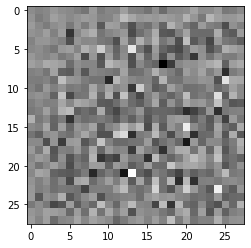

In [8]:
generator = create_generator(100)
latent_noise = tf.random.normal([1, 100])
generated_output = generator(latent_noise, training = False)

plt.imshow(generated_output[0, :, :, 0], cmap = 'gray')

Look at the discriminator's output.

In [9]:
discriminator = create_discriminator()
classify = discriminator(generated_output)
print(classify)

tf.Tensor([[-0.00045408]], shape=(1, 1), dtype=float32)


Now both the discriminator and the generator models are working. We can preceed to design the training process. Unlike normal CNN, we need to manually calculate the loss for our DCGAN model and backpropagate based on that loss.

Since the discriminator is classifying between two classes (True and Fake), use binary cross entropy.

Because we are feeding the discriminator real and fake inputs seperately, the total loss for the discriminator is the sum of the loss from predicting each classes.

The generator's loss used in here is very simple: It is the loss of the discriminator classifying fake images as real. So when we train the model, the generator is learning to generate fake output that can fool the discriminator thus giving us fake images that looks like real.

In [10]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(real_output, fake_output):
    
    real_loss = loss(tf.ones_like(real_output), real_output)
    fake_loss = loss(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    
    gen_loss = loss(tf.ones_like(fake_output), fake_output)
    
    return gen_loss

Then we define optimizers variables for models so that we can train and perform backpropagation.

In [12]:
dis_opt = tf.keras.optimizers.Adam(lr = 5e-5)
gen_opt = tf.keras.optimizers.Adam(lr = 5e-5)

Losses and optimizers are up, we can proceed to write the training process. Because we need to manually call the losses and optimizers, we need to write our own iteration loop instead of using the model.fit() API.

In [82]:
@tf.function   #  Call out tf.function to let the gradient tape alter models.
def step_train(real_input, batch_size, noise_dim, print_log = False):
    
    gen_input = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as dis_tape, tf.GradientTape() as gen_tape:
        
        fake_input = generator(gen_input, training = True)
        
        real_output = discriminator(real_input, training = True)
        fake_output = discriminator(fake_input, training = True)
        
        dis_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        
    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    dis_grad = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grad, generator.trainable_variables))
    dis_opt.apply_gradients(zip(dis_grad, discriminator.trainable_variables))
    
    if print_log:
        tf.print('Discriminator loss: ', dis_loss, '           Generator loss: ', gen_loss)  # For debug use: sometimes the model will not be trained if hyperparameters are not correctly set.

In [14]:
def fit(real_input, batch_size, noise_dim, epochs):  # Use a simple for loop to train over epochs
    
    n = 0
    batches = np.copy(real_input)
    batches = tf.data.Dataset.from_tensor_slices(batches).shuffle(len(real_input)).batch(batch_size, drop_remainder = True)
    
    for epoch in range(epochs):
        n = epoch
        print('Epoch {}/{}'.format(n+1, epochs))
        for batch in batches:
            
            step_train(batch, batch_size, noise_dim)  # Perform train on batch
       
        

In [16]:
fit(train_set, 128, 100, 100)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

Test the generator.

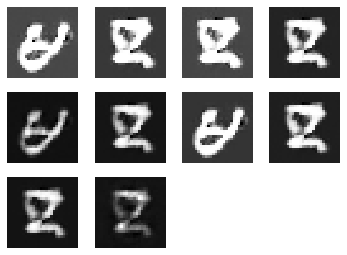

In [17]:
test_input = tf.random.normal([12, 100])
prediction = generator.predict(test_input)

fig = plt.figure(figsize = (6, 6))
for i in range(10):
    plt.subplot(4, 4, i+1)
    plt.imshow(prediction[i, :, :, 0] * 255., cmap = 'gray')
    plt.axis('off')
    

We see the generator is consistently producing images that are very similar to each other. It might be a sign of overfit that the generator memorized some specific input patterns to fool the discriminator. Plus, the Conv2DTranspose is using tanh as output activation while our input uses [0, 1] normalization for the ease of training the discriminator. Thus, we should also try scaling the input to be also in [-1, 1] tanh range. 

Advanced solutions to the problem is to use techniques like deduplication. In here, we will tune hyperparameters instead.

Tuning the model: Use ReLU instead of LeakyReLU for the generator. Plus, remove the activation function for the dense layer.

In [74]:
def create_generator(noise_dim):
    
    model = Sequential()
    model.add(Dense(7*7*256, input_shape = (noise_dim, ), use_bias = False))
    model.add(BatchNormalization())
    #model.add(ReLU())
    
    model.add(Reshape((7,7,256)))
    
    
    #This Conv2DTranspose layer will upsample the (7, 7, 256) input from the Dense layer to (7, 7, 128) feature maps
    model.add(Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    
    #This will upsaample to (14, 14, 64) feature maps
    model.add(Conv2DTranspose(64, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    
    #Same reason, this will upsample to (28, 28, 32) feature maps. Now each feature map is in the desired output image size.
    #So we can stop the upsampling and combine all feature maps into one complete image.
    model.add(Conv2DTranspose(32, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    
    model.add(Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation = 'tanh'))
    assert model.output_shape == (None, 28, 28, 1)  # Make sure we are getting the desired output
    
    return model

In [75]:
generator = create_generator(100)

Rescale the input data into tanh range.

In [76]:
new_train = np.copy(train_set)
new_train *= 255.
new_train -= 127.5
new_train /= 127.5
new_train = new_train.reshape(-1, 28, 28, 1).astype('float32')

Try to tune the optimizer's beta1 to use a shorter moving average period.

In [77]:
dis_opt = tf.keras.optimizers.Adam(lr = 1e-4, beta_1 = 0.5)
gen_opt = tf.keras.optimizers.Adam(lr = 1e-4, beta_1 = 0.5)

We also add a function to display the generator's current capability at each epoch end. To have a consistent representation of the model's capability, we create a fixed test noise input and use it whole the time during the training.

In [78]:
test_input = tf.random.normal([12, 100])

In [79]:
def plot_generator(model, test_input):
    
    prediction = model(test_input, training = False)
    
    fig = plt.figure(dpi = 128, figsize = (6, 6))
    
    for i in range(prediction.shape[0]):
        
        plt.subplot(4, 4, i+1)
        plt.imshow(prediction[i, :, :, 0], cmap = 'gray')
        plt.axis('off')
    
    plt.show()

In [80]:
def fit(real_input, batch_size, noise_dim, epochs):
    
    n = 0
    batches = np.copy(real_input)
    batches = tf.data.Dataset.from_tensor_slices(batches).shuffle(len(real_input)).batch(batch_size, drop_remainder = True)
    
    for epoch in range(epochs):
        n = epoch
        
        print('Epoch {}/{}'.format(n+1, epochs))
        for batch in batches:
            
            step_train(batch, batch_size, noise_dim)
            
        clear_output(wait = True)
        plot_generator(generator, test_input)

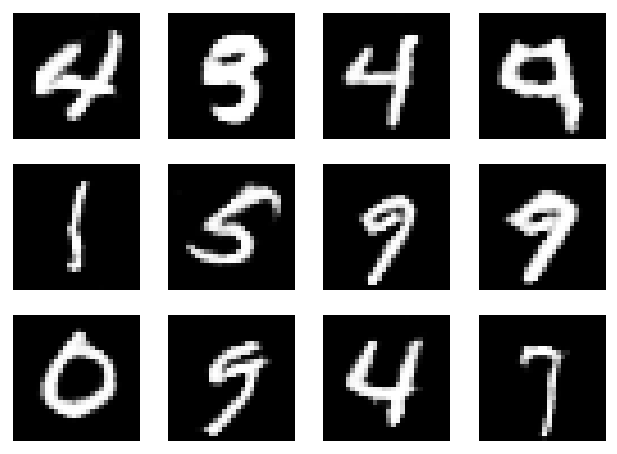

In [83]:
fit(new_train, 256, 100, 50)

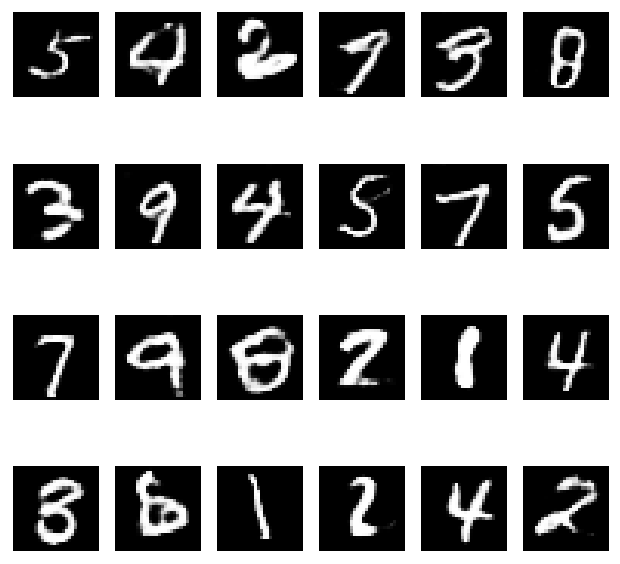

In [86]:
new_prediction = generator.predict(tf.random.normal([24, 100]))

fig = plt.figure(dpi = 128, figsize = (6,6))
for i in range(24):
    
    plt.subplot(4, 6, i+1)
    plt.imshow(new_prediction[i, :, :, 0], cmap = 'gray')
    plt.axis('off')

Now the model is generating real-looking digits instead of images that are very similar to each other, and this is the simple implementation of a DCGAN model using tensorflow and keras.